# Домашнее задание Ⅶ

## Задача

> На основе программы, реализующей составной метод Симпсона для численного интегрирования произвольных регулярных функций, вычислить следующий интегралы $$I_1=\int_0^1\dfrac{\arctan{\sqrt{x}}}{x}\mathrm{d}x$$ $$I_2=\int_1^\infty\sqrt{x}\sin{(x^3)}\mathrm{d}x$$ с точностью $\varepsilon=10^{-4}$.

Параметры задачи и ответ с точностью $10^{-13}$

In [8]:
eps = 1e-4
I1 = 1.8319311883544
I2 = 0.2109258446229

## Реализация составного метода Симпсона

На равномерной сетке $x_k=a+kh,\ k=0,1,\ldots,n,\ h=\dfrac{b-a}{n}$ для функции $f\in C^4[a,b]$

$$\int_a^b f(x)\mathrm{d}x=I+E,$$

$$I=\dfrac{h}{6}\sum\limits_{k=0}^{n-1}\left(f(x_k)+4f\left(\dfrac{x_k+x_{k+1}}{2}\right)+f(x_{k+1})\right),$$

$$|E|\le\dfrac{(b-a)}{2880}h^4\max_{x\in[a,b]}|f^{(4)}(x)|.$$

Потребовав точность $|\int_a^b f(x)\mathrm{d}x-I|\le\varepsilon$ найдем минимальное число узлов

$$n\ge\sqrt[4]{\dfrac{(b-a)^5 M_4}{2880\varepsilon}}$$

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable


def simpson(
        f: Callable[[np.float32], np.float32], 
        a: np.float32, 
        b: np.float32, 
        m4: np.float32,
        eps: np.float32 
    ):
    n: np.int32 = np.int32(np.ceil(((b-a)**5*m4/2880/eps)**(1/4)))
    h: np.float32 = (b-a)/n
    s: np.float32 = 0
    for k in range(n):
        x = a+k*h
        s += f(x) + 4*f(x+h/2) + f(x+h)
    return s*h/6

## Вычисление $I_1$

### Замена

$$\int_0^1\dfrac{\arctan{\sqrt{x}}}{x}\mathrm{d}x=\left[\begin{array}{cc}x=t^2\\\mathrm{d}x=2t\ \mathrm{d}t\end{array}\right]=2\int_0^1\dfrac{\arctan{t}}{t}\mathrm{d}t$$

Доопределим подынтегральную функцию $f(t)$ в 0 ее пределом
$$\lim_{t\to0}\dfrac{\arctan{t}}{t}=[\arctan{t}\sim t]=\lim_{t\to0}\dfrac{t}{t}=1$$

Ее четвертая производная, также доопределенная в 0 своим пределом
$$g(t)=\dfrac{\mathrm{d}^4}{\mathrm{d}t^4}\left(\dfrac{\arctan{t}}{t}\right)=\dfrac{8\left(3\arctan{t}-\dfrac{t(12t^6+14t^4+11t^2+3)}{(t^2 + 1)^4}\right)}{t^5}$$
$$\lim_{t\to0}g(t)=[\text{using Taylor expansion}]=4.8$$

Используя `simpson` с $M_4=4.8$ (по графику) и точностью $\varepsilon/2$, вычислим
$$2\int_0^1\dfrac{\arctan{t}}{t}\mathrm{d}t$$ 

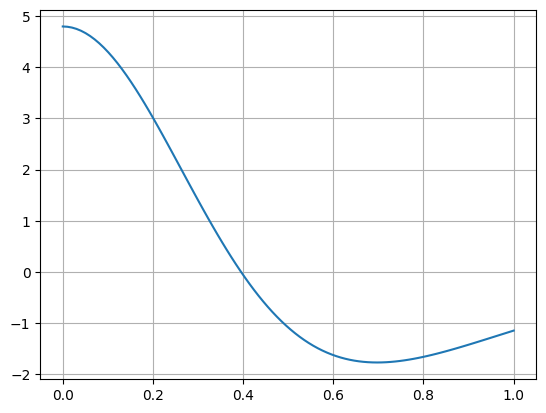

I = 1.8319335729024078
E = 2.3845480077167025e-06


In [10]:
def f(t: np.float32) -> np.float32:
    return 1 if t==0 else np.arctan(t)/t

def g(t: np.float32) -> np.float32:
    return 4.8 if t==0 else 8*(3*np.arctan(t)-t*(12*t**6+14*t**4+11*t**2+3)/(t**2+1)**4)/t**5

t = np.linspace(0, 1, 100)
plt.plot(t, np.vectorize(g)(t))
plt.grid()
plt.show()
m4 = 4.8

I = 2*simpson(f, 0, 1, m4, eps/2)
E = np.abs(I-I1)
print(f'I = {I}\nE = {E}')

### Регуляризация (метод Канторовича)

Разложение в ряд Тейлора дает

$$\dfrac{\arctan{\sqrt{x}}}{x}=\dfrac{\sqrt{x}-\frac{1}{3}x^{3/2}+\frac{1}{5}x^{5/2}-\ldots}{x}$$

Тогда следующая функция регулярна в 0 вместе мо своей 4-ой производной

$$f(x)=\dfrac{\arctan{\sqrt{x}}-\sqrt{x}}{x}+\dfrac{1}{3}\sqrt{x}-\dfrac{1}{5}x^{3/2}+\dfrac{1}{7}x^{5/2}-\dfrac{1}{9}x^{7/2}=-\dfrac{1}{11}x^{9/2}+\dfrac{1}{13}x^{11/2}\ldots$$

$f^{(4)}(x)$ можно ограничить  максимумом абсолютного значения первого члена ряда

$$M_4\le\dfrac{1}{11}\cdot\dfrac{9\cdot7\cdot5\cdot3}{2\cdot2\cdot2\cdot2}$$

Представим

$$\int_0^1\dfrac{\arctan{\sqrt{x}}}{x}\mathrm{d}x=\int_0^1f(x)\mathrm{d}x+\int_0^1\left(\dfrac{1}{\sqrt{x}}-\dfrac{1}{3}\sqrt{x}+\dfrac{1}{5}x^{3/2}-\dfrac{1}{7}x^{5/2}+\dfrac{1}{9}x^{7/2}\right)\mathrm{d}x$$

Первый интеграл вычисляется с помощью `simpson`, значение второго легко находится по формуле $\int_0^1 x^k\mathrm{d}x=\frac{1}{k+1}$

In [11]:
def f(x: np.float32) -> np.float32:
    if x == 0:
        return 0
    x = np.sqrt(x)
    return (np.arctan(x)-x)/x**2+x/3-x**3/5+x**5/7-x**7/9

m4 = 9*7*5*3/2/2/2/2/11
I = simpson(f, 0, 1, m4, eps)+2/1/1-2/3/3+2/5/5-2/7/7+2/9/9
E = np.abs(I-I1)
print(f'I = {I}\nE = {E}')

I = 1.8319261511224956
E = 5.037231904481132e-06


*Комментарий.* Почленное интегрирование ряда дает удвоенную постоянную Каталана (сумма знакочередующегося ряда обратных квадратов нечетных чисел), чему собственно и равен искомый интеграл.

### Интегрирование по частям

Нет очевидных разделений на части

### Выделение особенности

$$\int_0^1\dfrac{\arctan{\sqrt{x}}}{x}\mathrm{d}x=\int_0^\delta\dfrac{\arctan{\sqrt{x}}}{x}\mathrm{d}x+\int_\delta^1\dfrac{\arctan{\sqrt{x}}}{x}\mathrm{d}x$$

Возьмем $\delta=(\varepsilon/4)^2$, и для всех $t\ge0$ верно $\arctan{t}\le t$, поэтому
$$\int_0^\delta\dfrac{\arctan{\sqrt{x}}}{x}\mathrm{d}x\le\int_0^\delta\dfrac{\sqrt{x}}{x}\mathrm{d}x=2\sqrt{\delta}=\dfrac{\varepsilon}{2}$$

Этот способ неприменим, поскольку четвертая производная подынтегральной функции стремится к $\infty$ при $x\to0$ и на величинах порядка $\delta$ принимает значения $\ge 10^{36}$.



### Замена + выделение особенности

$$\int_0^1\dfrac{\arctan{\sqrt{x}}}{x}\mathrm{d}x=\left[\begin{array}{cc}\ln x=-t\\\dfrac{\mathrm{d}x}{x}=-\mathrm{d}t\end{array}\right]=\int_0^\infty\arctan{\exp{\left(-\dfrac{t}{2}\right)}}\mathrm{d}t=\int_0^\delta\arctan{\exp{\left(-\dfrac{t}{2}\right)}}\mathrm{d}t+\int_\delta^\infty\arctan{\exp{\left(-\dfrac{t}{2}\right)}}\mathrm{d}t$$

Положим $\delta=-2\ln\dfrac{\varepsilon}{4}$ и вычислим первый интеграл `simpson` с точностью $\varepsilon/2$ и по графику найдем $M_4\le0.048$

$$g(t)=\dfrac{\mathrm{d}^4}{\mathrm{d}t^4}\left(\arctan{\exp{\left(-\dfrac{t}{2}\right)}}\right)=\dfrac{e^{t/2}(e^{3t}-23e^{2t}+23e^t-1)}{16(e^t+1)^4}$$

Для второго же интеграла выполняется оценка

$$\int_\delta^\infty\arctan{\exp{\left(-\dfrac{t}{2}\right)}}\mathrm{d}t\le\int_\delta^\infty\exp{\left(-\dfrac{t}{2}\right)}\mathrm{d}t=2\exp{\left(-\dfrac{\delta}{2}\right)}=\dfrac{\varepsilon}{2}$$

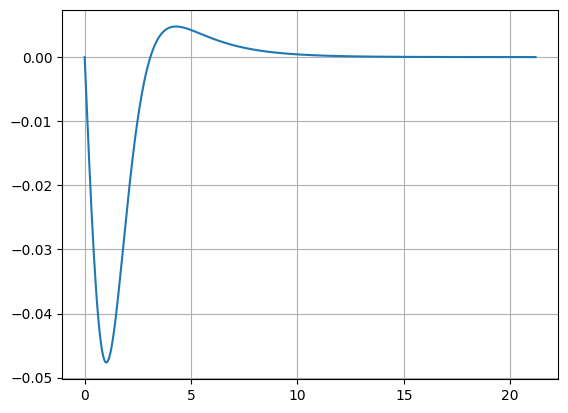

I = 1.8318782297013525
E = 5.295865304755232e-05


In [12]:
def f(t: np.float32) -> np.float32:
    return np.arctan(np.exp(-t/2))

def g(t: np.float32) -> np.float32:
    e: np.float32 = np.exp(t)
    return np.exp(t/2)*(e**3-23*e**2+23*e-1)/16/(e+1)**4

d = -2*np.log(eps/4)

t = np.linspace(0, d, 1000)
plt.plot(t, g(t))
plt.grid()
plt.show()
m4 = 0.048

I = simpson(f, 0, d, m4, eps/2)
E = np.abs(I-I1)
print(f'I = {I}\nE = {E}')


## Вычисление $I_2$

Сделаем замену и дважды применим формулу интегрирования по частям

$$\int_1^\infty\sqrt{x}\sin{(x^3)}\mathrm{d}x=\int_1^\infty\dfrac{\sqrt{x}}{3x^2}\sin{(x^3)}\mathrm{d}(x^3)=\int_1^\infty\dfrac{\sin{t}}{3\sqrt{t}}\mathrm{d}t=-\left.\dfrac{\cos{t}}{3\sqrt{t}}\right|_1^\infty-\dfrac{1}{6}\int_1^\infty\dfrac{\cos{t}}{t^{3/2}}\mathrm{d}t=\\=\dfrac{\cos{1}}{3}+\dfrac{\sin{1}}{6}-\dfrac{1}{4}\int_1^\infty\dfrac{\sin{t}}{t^{5/2}}\mathrm{d}t$$

Выделим особенность, положив $C=(3\varepsilon)^{-2/3}$

$$\int_1^\infty\dfrac{\sin{t}}{t^{5/2}}\mathrm{d}t=\int_1^C\dfrac{\sin{t}}{t^{5/2}}\mathrm{d}t+\int_C^\infty\dfrac{\sin{t}}{t^{5/2}}\mathrm{d}t,\quad\left|\int_C^\infty\dfrac{\sin{t}}{t^{5/2}}\mathrm{d}t\right|\le\int_C^\infty\dfrac{\mathrm{d}t}{t^{5/2}}=\dfrac{C^{-3/2}}{3/2}=2\varepsilon$$

$$g(t)=\dfrac{\mathrm{d}^4}{\mathrm{d}t^4}\left(\dfrac{\sin{t}}{t^{5/2}}\right)=\dfrac{40t(4t^2-63)\cos{t}+(16t^4-840t^2+3465)\sin{t}}{16t^{13/2}}$$

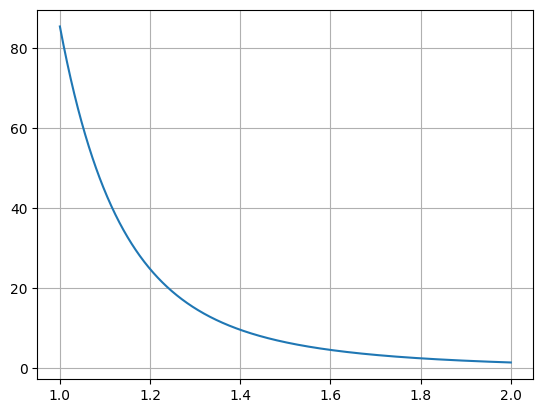

I = 0.21092547683797142
E = 3.677849285954604e-07


In [13]:
def f(t: np.float32) -> np.float32:
    return np.sin(t)/t**(5/2)

def g(t: np.float32) -> np.float32:
    return (40*t*(4*t**2-63)*np.cos(t)+(16*t**4-840*t**2+3465))/(16*t**(13/2))

c = (3*eps)**(-2/3)
t = np.linspace(1, 2, 1000)
plt.plot(t, g(t))
plt.grid()
plt.show()
m4 = 90

I = np.cos(1)/3+np.sin(1)/6-simpson(f, 1, c, m4, 2*eps)/4
E = np.abs(I-I2)
print(f'I = {I}\nE = {E}')